<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# Seeking the Invisible: Dark Matter Search with Neural Networks at ATLAS 

<a id='contents'></a>

In [1]:
import pandas as pd # to store data as dataframe
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting

<a id='processes'></a>

## Processes

The Dark Matter process we'll be looking for is <font color='red'>'DM_300'</font>, which we call "<font color='purple'>signal</font>". The others are processes that may look like our <font color='purple'>signal</font>, so we have to consider them as well, which we call "<font color='red'>backgrounds</font>".

In [2]:
processes = ['Non-resonant_ll','Z+jets','WZ','ZZ','DM_300']

This is where the data files are read

In [3]:
data_all = {} # dictionary to hold all data
for s in processes: # loop over different processes
    print(s)
    data_all[s] = pd.read_csv('https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/csv/DM_ML_notebook/'+s+'.csv') # read data files

Non-resonant_ll
Z+jets
WZ
ZZ
DM_300


<a id='NN_vars'></a>

## Neural Network variables

Choose variables for use in the Neural Network

In [4]:
data_NN = {} # define empty dictionary to hold dataframes that will be used to train the NN

NN_inputs = [
             #'sum_lep_charge', 
             'lead_lep_pt', 
             'sublead_lep_pt', 
             'mll',
             'ETmiss', 
             #'dRll', 
             'dphi_pTll_ETmiss', 
             'fractional_pT_difference',
             'ETmiss_over_HT', 
             #'N_bjets'
            ] # list of variables for Neural Network

for s in processes: # loop over the different processes
    data_NN[s] = data_all[s][NN_inputs].copy() # copy variables into data for NN

The type of ML algorithm that accomplishes classification is called a Machine Learning classifier. Although there are other types of ML models that accomplish other goals, classifiers are widely used in HEP. More specifically, *binary classifiers* are used to distinguish <font color='purple'>signal</font> from <font color='red'>background</font> for particle collision events detected by instruments such as ATLAS. In fact, this is an endeavour you have already explored and attempted to optimize by choosing selection cuts. Hence, we shall focus solely on ML classifiers for this course.

[Back to contents](#contents)

Organise data ready for the NN

In [5]:
# for NNs data is usually organised                                                                                                                                           
# into one 2D array of shape (n_samples x n_features)                                                                                                                             
# containing all the data and one array of categories                                                                                                                             
# of length n_samples  

all_processes = [] # define empty list that will contain all features for the MC
for s in processes: # loop over the different keys in the dictionary of dataframes
    all_processes.append(data_NN[s]) # append the MC dataframe to the list containing all MC features
X = np.concatenate(all_processes) # merge the list of MC dataframes into a single 2D array of features, called X

all_y = [] # define empty list that will contain labels whether an event in signal or background
for s in processes: # loop over the different keys in the dictionary of dataframes
    if 'DM' in s: # only signal MC should pass this
        all_y.append(np.ones(data_NN[s].shape[0])) # signal events are labelled with one
    else: # background if gets here
        all_y.append(np.zeros(data_NN[s].shape[0])) # background events are labelled with zero
y = np.concatenate(all_y) # merge the list of labels into a single 1D array of labels, called y

<a id='train_test'></a>

## Training and testing

Isn’t it the dream of every student to get very similar exam questions to ones they practiced with? It is easy to score well when you are familiarized with the problems being asked. To guarantee a fair test, teachers make sure to split their bank of questions into a training and a testing set. As such, students will have plenty to practice but still receive unseen questions on the test. The same applies to neural networks! 

Before running the algorithm, we must first split the input data into the two sets: training and testing. Furthermore, this separation has to be randomized to avoid selection bias (just like when cutting a deck of cards). Now, let’s see how this process is coded. 

In [6]:
from sklearn.model_selection import train_test_split

# make train and test sets
X_train,X_test,y_train,y_test = train_test_split(X, y)

In [7]:
"""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # initialise StandardScaler

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
"""

'\nfrom sklearn.preprocessing import StandardScaler\nscaler = StandardScaler() # initialise StandardScaler\n\n# Fit only to the training data\nscaler.fit(X_train)\n\n# Now apply the transformations to the data:\nX_train = scaler.transform(X_train)\n'

# Neural Net using Keras

In [8]:
from keras.models import Sequential
from keras.layers import Dense

2022-06-17 17:40:24.591995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc10-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc10-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc10-opt/jre/lib/amd64:/cvm

In [9]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=X.shape[1], activation='sigmoid'))
model.add(Dense(8, activation='sigmoid')) # relu
model.add(Dense(1, activation='sigmoid'))

2022-06-17 17:40:30.237149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc10-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc10-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc10-opt/jre/lib/amd64:/cvmfs/sft.cer

In [10]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=3000, batch_size=200)

2022-06-17 17:40:30.395291: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-17 17:40:30.396696: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2399845000 Hz


Epoch 1/3000
89/89 [==============================] - 1s 2ms/step - loss: 0.9559 - accuracy: 0.0207
Epoch 2/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.6139 - accuracy: 0.7632
Epoch 3/3000
89/89 [==============================] - 0s 2ms/step - loss: 0.4077 - accuracy: 0.9793
Epoch 4/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.2959 - accuracy: 0.9793
Epoch 5/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.2299 - accuracy: 0.9793
Epoch 6/3000
89/89 [==============================] - 0s 2ms/step - loss: 0.1895 - accuracy: 0.9793
Epoch 7/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.1638 - accuracy: 0.9793
Epoch 8/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.1465 - accuracy: 0.9793
Epoch 9/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.1346 - accuracy: 0.9793
Epoch 10/3000
89/89 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9793

89/89 [==============================] - 0s 1ms/step - loss: 0.0983 - accuracy: 0.9793
Epoch 83/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0982 - accuracy: 0.9793
Epoch 84/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0982 - accuracy: 0.9793
Epoch 85/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0981 - accuracy: 0.9793
Epoch 86/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0980 - accuracy: 0.9793
Epoch 87/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0979 - accuracy: 0.9793
Epoch 88/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0979 - accuracy: 0.9793
Epoch 89/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0979 - accuracy: 0.9793
Epoch 90/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0979 - accuracy: 0.9793
Epoch 91/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0978 - accuracy: 0.9793
Epoc

89/89 [==============================] - 0s 1ms/step - loss: 0.0977 - accuracy: 0.9793
Epoch 163/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0976 - accuracy: 0.9793
Epoch 164/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0976 - accuracy: 0.9793
Epoch 165/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0976 - accuracy: 0.9793
Epoch 166/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0976 - accuracy: 0.9793
Epoch 167/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0976 - accuracy: 0.9793
Epoch 168/3000
89/89 [==============================] - 0s 2ms/step - loss: 0.0976 - accuracy: 0.9793
Epoch 169/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0976 - accuracy: 0.9793
Epoch 170/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0976 - accuracy: 0.9793
Epoch 171/3000
89/89 [==============================] - 0s 2ms/step - loss: 0.0977 - accuracy: 0.

89/89 [==============================] - 0s 1ms/step - loss: 0.0972 - accuracy: 0.9793
Epoch 243/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0973 - accuracy: 0.9793
Epoch 244/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0973 - accuracy: 0.9793
Epoch 245/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0973 - accuracy: 0.9793
Epoch 246/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0973 - accuracy: 0.9793
Epoch 247/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0973 - accuracy: 0.9793
Epoch 248/3000
89/89 [==============================] - 0s 2ms/step - loss: 0.0974 - accuracy: 0.9793
Epoch 249/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0973 - accuracy: 0.9793
Epoch 250/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0973 - accuracy: 0.9793
Epoch 251/3000
89/89 [==============================] - 0s 2ms/step - loss: 0.0974 - accuracy: 0.

89/89 [==============================] - 0s 1ms/step - loss: 0.0971 - accuracy: 0.9793
Epoch 323/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0972 - accuracy: 0.9793
Epoch 324/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0971 - accuracy: 0.9793
Epoch 325/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0971 - accuracy: 0.9793
Epoch 326/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0971 - accuracy: 0.9793
Epoch 327/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0971 - accuracy: 0.9793
Epoch 328/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0972 - accuracy: 0.9793
Epoch 329/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0972 - accuracy: 0.9793
Epoch 330/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0971 - accuracy: 0.9793
Epoch 331/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0971 - accuracy: 0.

89/89 [==============================] - 0s 1ms/step - loss: 0.0970 - accuracy: 0.9793
Epoch 403/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0969 - accuracy: 0.9793
Epoch 404/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0969 - accuracy: 0.9793
Epoch 405/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0969 - accuracy: 0.9793
Epoch 406/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0969 - accuracy: 0.9793
Epoch 407/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0970 - accuracy: 0.9793
Epoch 408/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0969 - accuracy: 0.9793
Epoch 409/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0969 - accuracy: 0.9793
Epoch 410/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0969 - accuracy: 0.9793
Epoch 411/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0969 - accuracy: 0.

89/89 [==============================] - 0s 1ms/step - loss: 0.0968 - accuracy: 0.9793
Epoch 483/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0969 - accuracy: 0.9793
Epoch 484/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.9793
Epoch 485/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0968 - accuracy: 0.9793
Epoch 486/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0969 - accuracy: 0.9793
Epoch 487/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.9793
Epoch 488/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.9793
Epoch 489/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.9793
Epoch 490/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.9793
Epoch 491/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.

89/89 [==============================] - 0s 1ms/step - loss: 0.0964 - accuracy: 0.9793
Epoch 563/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0965 - accuracy: 0.9793
Epoch 564/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0964 - accuracy: 0.9793
Epoch 565/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0965 - accuracy: 0.9793
Epoch 566/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0964 - accuracy: 0.9793
Epoch 567/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0965 - accuracy: 0.9793
Epoch 568/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0964 - accuracy: 0.9793
Epoch 569/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0964 - accuracy: 0.9793
Epoch 570/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0965 - accuracy: 0.9793
Epoch 571/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0965 - accuracy: 0.

89/89 [==============================] - 0s 1ms/step - loss: 0.0964 - accuracy: 0.9793
Epoch 643/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0960 - accuracy: 0.9793
Epoch 644/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0963 - accuracy: 0.9793
Epoch 645/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0960 - accuracy: 0.9793
Epoch 646/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0960 - accuracy: 0.9793
Epoch 647/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0960 - accuracy: 0.9793
Epoch 648/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0959 - accuracy: 0.9793
Epoch 649/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0962 - accuracy: 0.9793
Epoch 650/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0961 - accuracy: 0.9793
Epoch 651/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0960 - accuracy: 0.

89/89 [==============================] - 0s 1ms/step - loss: 0.0953 - accuracy: 0.9793
Epoch 723/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0953 - accuracy: 0.9793
Epoch 724/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0955 - accuracy: 0.9793
Epoch 725/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0952 - accuracy: 0.9793
Epoch 726/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0953 - accuracy: 0.9793
Epoch 727/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0950 - accuracy: 0.9793
Epoch 728/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0955 - accuracy: 0.9793
Epoch 729/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0957 - accuracy: 0.9793
Epoch 730/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0953 - accuracy: 0.9793
Epoch 731/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0951 - accuracy: 0.

89/89 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.9793
Epoch 803/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.9793
Epoch 804/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0952 - accuracy: 0.9793
Epoch 805/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0947 - accuracy: 0.9793
Epoch 806/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0947 - accuracy: 0.9793
Epoch 807/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0949 - accuracy: 0.9793
Epoch 808/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.9793
Epoch 809/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0947 - accuracy: 0.9793
Epoch 810/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0943 - accuracy: 0.9793
Epoch 811/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0948 - accuracy: 0.

89/89 [==============================] - 0s 1ms/step - loss: 0.0941 - accuracy: 0.9793
Epoch 883/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0946 - accuracy: 0.9793
Epoch 884/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0942 - accuracy: 0.9793
Epoch 885/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0944 - accuracy: 0.9793
Epoch 886/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0943 - accuracy: 0.9793
Epoch 887/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.9793
Epoch 888/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0950 - accuracy: 0.9793
Epoch 889/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0944 - accuracy: 0.9793
Epoch 890/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0947 - accuracy: 0.9793
Epoch 891/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0943 - accuracy: 0.

89/89 [==============================] - 0s 1ms/step - loss: 0.0943 - accuracy: 0.9793
Epoch 963/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.9793
Epoch 964/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0942 - accuracy: 0.9793
Epoch 965/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0942 - accuracy: 0.9793
Epoch 966/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0940 - accuracy: 0.9793
Epoch 967/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0939 - accuracy: 0.9793
Epoch 968/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0943 - accuracy: 0.9793
Epoch 969/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0939 - accuracy: 0.9793
Epoch 970/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0941 - accuracy: 0.9793
Epoch 971/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0942 - accuracy: 0.

89/89 [==============================] - 0s 1ms/step - loss: 0.0939 - accuracy: 0.9793
Epoch 1043/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9793
Epoch 1044/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0950 - accuracy: 0.9793
Epoch 1045/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9793
Epoch 1046/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0951 - accuracy: 0.9793
Epoch 1047/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0941 - accuracy: 0.9793
Epoch 1048/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0948 - accuracy: 0.9793
Epoch 1049/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - accuracy: 0.9793
Epoch 1050/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0939 - accuracy: 0.9793
Epoch 1051/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0941 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.9793
Epoch 1122/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0941 - accuracy: 0.9793
Epoch 1123/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0944 - accuracy: 0.9793
Epoch 1124/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0940 - accuracy: 0.9793
Epoch 1125/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.9793
Epoch 1126/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.9793
Epoch 1127/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0939 - accuracy: 0.9793
Epoch 1128/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - accuracy: 0.9793
Epoch 1129/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0939 - accuracy: 0.9793
Epoch 1130/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0942 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0944 - accuracy: 0.9793
Epoch 1201/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - accuracy: 0.9793
Epoch 1202/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9793
Epoch 1203/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 1204/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.9793
Epoch 1205/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.9793
Epoch 1206/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0950 - accuracy: 0.9793
Epoch 1207/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - accuracy: 0.9793
Epoch 1208/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.9793
Epoch 1209/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - accuracy: 0.9793
Epoch 1280/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9793
Epoch 1281/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0941 - accuracy: 0.9793
Epoch 1282/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.9793
Epoch 1283/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - accuracy: 0.9793
Epoch 1284/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9793
Epoch 1285/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.9793
Epoch 1286/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0943 - accuracy: 0.9793
Epoch 1287/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - accuracy: 0.9793
Epoch 1288/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0939 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 1359/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9793
Epoch 1360/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 1361/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 1362/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 1363/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 1364/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0939 - accuracy: 0.9793
Epoch 1365/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0940 - accuracy: 0.9793
Epoch 1366/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 1367/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 1438/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0941 - accuracy: 0.9793
Epoch 1439/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 1440/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 1441/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 1442/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9793
Epoch 1443/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.9793
Epoch 1444/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 1445/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0944 - accuracy: 0.9793
Epoch 1446/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 1517/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1518/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9793
Epoch 1519/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.9793
Epoch 1520/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 1521/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 1522/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - accuracy: 0.9793
Epoch 1523/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9793
Epoch 1524/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9793
Epoch 1525/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0941 - accuracy: 0.9793
Epoch 1596/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 1597/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 1598/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1599/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 1600/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1601/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1602/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 1603/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 1604/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 1675/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 1676/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.9793
Epoch 1677/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 1678/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 1679/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1680/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - accuracy: 0.9793
Epoch 1681/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.9793
Epoch 1682/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 1683/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 1754/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 1755/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 1756/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1757/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 1758/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 1759/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 1760/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0940 - accuracy: 0.9793
Epoch 1761/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 1762/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 1833/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 1834/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1835/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 1836/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0939 - accuracy: 0.9793
Epoch 1837/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 1838/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1839/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - accuracy: 0.9793
Epoch 1840/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 1841/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 1912/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 1913/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 1914/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1915/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 1916/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1917/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 1918/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 1919/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1920/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 1991/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 1992/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1993/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 1994/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 1995/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 1996/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 1997/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 1998/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 1999/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2070/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 2071/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 2072/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 2073/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 2074/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 2075/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2076/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2077/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2078/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2149/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 2150/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 2151/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 2152/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2153/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 2154/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2155/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0938 - accuracy: 0.9793
Epoch 2156/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 2157/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9793
Epoch 2228/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2229/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 2230/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.9793
Epoch 2231/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2232/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2233/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2234/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2235/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 2236/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2307/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9793
Epoch 2308/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2309/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 2310/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2311/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2312/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2313/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 2314/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0935 - accuracy: 0.9793
Epoch 2315/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2386/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2387/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2388/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2389/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9793
Epoch 2390/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2391/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 2392/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 2393/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 2394/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 2465/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2466/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2467/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2468/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2469/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 2470/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 2471/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 2472/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2473/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9793
Epoch 2544/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9793
Epoch 2545/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 2546/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2547/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2548/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 2549/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2550/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2551/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 2552/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2623/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9793
Epoch 2624/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2625/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2626/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0923 - accuracy: 0.9793
Epoch 2627/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 2628/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2629/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 2630/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 2631/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - acc

89/89 [==============================] - 0s 2ms/step - loss: 0.0926 - accuracy: 0.9793
Epoch 2702/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 2703/3000
89/89 [==============================] - 0s 2ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2704/3000
89/89 [==============================] - 0s 2ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 2705/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9793
Epoch 2706/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9793
Epoch 2707/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9793
Epoch 2708/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2709/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2710/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 2781/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2782/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2783/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2784/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 2785/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9793
Epoch 2786/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 2787/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2788/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0924 - accuracy: 0.9793
Epoch 2789/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 2860/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2861/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2862/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 2863/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2864/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2865/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 2866/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0931 - accuracy: 0.9793
Epoch 2867/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0933 - accuracy: 0.9793
Epoch 2868/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0926 - acc

89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2939/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 2940/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0932 - accuracy: 0.9793
Epoch 2941/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2942/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9793
Epoch 2943/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9793
Epoch 2944/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0930 - accuracy: 0.9793
Epoch 2945/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9793
Epoch 2946/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9793
Epoch 2947/3000
89/89 [==============================] - 0s 1ms/step - loss: 0.0925 - acc

In [12]:
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

552/552 [==============================] - 1s 799us/step - loss: 0.0941 - accuracy: 0.9793
Accuracy: 97.93


In [13]:
y_predicted_keras = model.predict(X_test)

In [14]:
from sklearn.metrics import roc_curve, auc
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [15]:
auc_keras = auc(fpr_keras, tpr_keras)

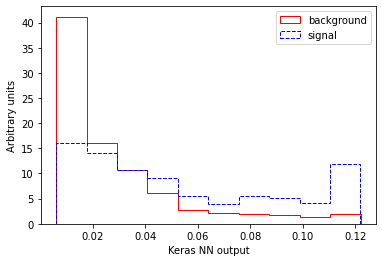

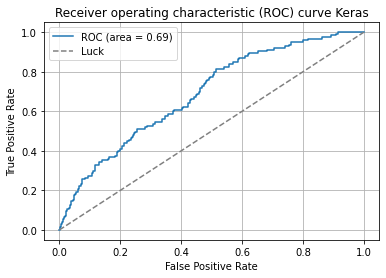

In [16]:
# we first plot the Neural Network output
signal_decisions = model.predict(X[y>0.5]).ravel() # get probabilities on signal
background_decisions = model.predict(X[y<0.5]).ravel() # get decisions on background

plt.hist(background_decisions, color='red', label='background', 
         histtype='step', # lineplot that's unfilled
         density=True ) # normalize to form a probability density
plt.hist(signal_decisions, color='blue', label='signal', 
         histtype='step', # lineplot that's unfilled
         density=True, # normalize to form a probability density
         linestyle='--' ) # dashed line
plt.xlabel('Keras NN output') # add x-axis label
plt.ylabel('Arbitrary units') # add y-axis label
plt.legend() # add legend


# we then plot the ROC
plt.figure() # make new figure 

from sklearn.metrics import roc_curve, auc

y_pred_keras = model.predict(X_test).ravel() # get probabilities on test set


# Compute ROC curve and area under the curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras) 

# Compute area under the curve for training set
roc_auc = auc(fpr_keras, # false positive rate 
              tpr_keras) # true positive rate

plt.plot(fpr_keras, tpr_keras, label='ROC (area = %0.2f)'%(roc_auc)) # plot test ROC curve
plt.plot([0, 1], # x from 0 to 1
         [0, 1], # y from 0 to 1
         '--', # dashed line
         color='grey', label='Luck')

plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.title('Receiver operating characteristic (ROC) curve Keras') # title
plt.legend() # add legend
plt.grid() # add grid

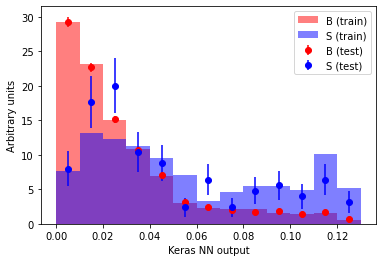

In [17]:
def compare_train_test(clf, X_train, y_train, X_test, y_test):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.predict(X[y<0.5]).ravel() # background
        d2 = clf.predict(X[y>0.5]).ravel() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.01 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.01 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='red', label='B (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='S (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='red', label='B (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='blue', label='S (test)' ) # Signal (test)
    
    plt.xlabel("Keras NN output") # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
    
compare_train_test(model, X_train, y_train, X_test, y_test) # call compare_train_test

[Back to contents](#contents)

<a id='preprocessing'></a>

## Data Preprocessing for Neural Network

A Neural Network may have difficulty converging if the data is not standardised. Note that you must apply the same standardisation to the test set for meaningful results. 

In [18]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [19]:
X_torch = torch.from_numpy(X)
X_torch

tensor([[7.4310e+01, 2.4997e+01, 7.7254e+01,  ..., 2.5298e+00, 8.2501e-02,
         5.2217e-01],
        [4.2211e+01, 3.9014e+01, 6.3456e+01,  ..., 2.0520e+00, 9.9824e-02,
         5.1975e-01],
        [4.1247e+01, 3.6669e+01, 6.1233e+01,  ..., 2.4582e+00, 2.1672e-01,
         6.9254e-01],
        ...,
        [1.2109e+02, 3.7106e+01, 9.0977e+01,  ..., 3.0689e+00, 1.9587e-01,
         1.0279e+00],
        [1.6618e+02, 7.9552e+01, 8.6337e+01,  ..., 3.1198e+00, 3.8813e-02,
         1.0270e+00],
        [6.3209e+01, 5.0553e+01, 7.4462e+01,  ..., 3.1394e+00, 5.6863e-02,
         7.1359e-01]], dtype=torch.float64)

In [20]:
y_torch = torch.from_numpy(y)
y_torch

tensor([0., 0., 0.,  ..., 1., 1., 1.], dtype=torch.float64)

In [21]:
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!

In [22]:
# Here we create our simple neural network. For more details here we are subclassing and
# inheriting from nn.Module, this is the most general way to create your networks and
# allows for more flexibility. I encourage you to also check out nn.Sequential which
# would be easier to use in this scenario but I wanted to show you something that
# "always" works.
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)
        """

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# Load Training and Test data
X_torch = torch.from_numpy(X)
y_torch = torch.from_numpy(y)
X_train_torch = torch.from_numpy(X_train)
y_train_torch = torch.from_numpy(y_train)
X_test_torch = torch.from_numpy(X_test)
y_test_torch = torch.from_numpy(y_test)

In [25]:
# Hyperparameters of our neural network which depends on the dataset, and
# also just experimenting to see what works well (learning rate for example).
input_size = X_torch.shape[0]
num_classes = 10
learning_rate = 0.01
batch_size = 64
num_epochs = 5

In [26]:
train_loader = DataLoader(dataset=X_torch, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=y_torch, batch_size=batch_size, shuffle=True)

In [ ]:
train_loader.shape

In [ ]:
X_torch.shape

In [ ]:
X_train_torch.shape

In [ ]:
X_test_torch.shape

In [ ]:
X_train_torch

In [ ]:
# Initialize network
model = NN(input_size=input_size, num_classes=num_classes).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Get to correct shape
        data = data.reshape(data.shape[0], -1)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

In [ ]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct/num_samples

In [ ]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

# Neural Net using Keras